In [10]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = r"C:\Users\prasi\Downloads\Flood satellite imagery\Water Bodies Dataset"
IMG_DIR  = os.path.join(DATA_DIR, "Images")
MSK_DIR  = os.path.join(DATA_DIR, "Masks")

# collect all file‑pairs
all_images = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
all_masks  = sorted(glob.glob(os.path.join(MSK_DIR, "*.jpg")))
print(f"Found {len(all_images)} images and {len(all_masks)} masks.")

Found 2841 images and 2841 masks.


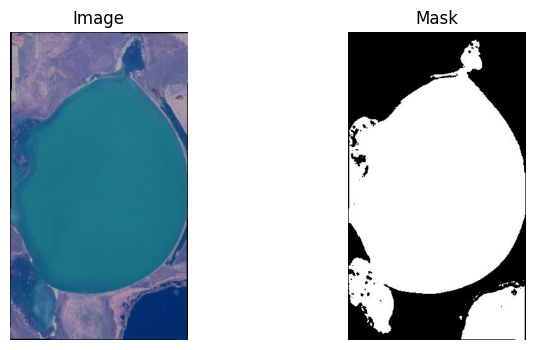

In [13]:
def show_sample(idx):
    img = plt.imread(all_images[idx])
    m   = plt.imread(all_masks[idx])
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.title("Image"); plt.imshow(img); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Mask");  plt.imshow(m, cmap="gray"); plt.axis("off")
    plt.savefig("sample_img.jpg", dpi=300)
    
show_sample(10)

In [4]:
# Split your data (80-10-10 split as an example)
split_1 = int(0.8 * len(all_images))
split_2 = int(0.9 * len(all_images))

train_images = all_images[:split_1]
train_masks  = all_masks[:split_1]

val_images = all_images[split_1:split_2]
val_masks  = all_masks[split_1:split_2]

test_images = all_images[split_2:]
test_masks  = all_masks[split_2:]

# Set image size and batch size
IMG_SIZE = 128
BATCH_SIZE = 8

# Preprocessing function
def preprocess(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)

    msk = tf.io.read_file(mask_path)
    msk = tf.image.decode_jpeg(msk, channels=1)

    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    msk = tf.image.resize(msk, [IMG_SIZE, IMG_SIZE], method="nearest")

    img = tf.cast(img, tf.float32) / 255.0
    msk = tf.cast(msk, tf.float32) / 255.0        # normalize 0–255 to 0–1
    msk = tf.cast(tf.round(msk), tf.int32) 

    '''msk = tf.cast(msk, tf.uint8)  # or tf.int32
'''
    '''msk = tf.cast(msk, tf.float32) / 255.0
    msk = tf.round(msk)  # binary mask'''

    return img, msk

# Dataset preparation function
def prepare(images, masks, batch=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    ds = (ds
          .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .batch(batch)
          .prefetch(tf.data.AUTOTUNE))
    return ds

# Prepare datasets
train_ds = prepare(train_images, train_masks)
val_ds   = prepare(val_images, val_masks)
test_ds  = prepare(test_images, test_masks)


In [ ]:
## 4. Define a U‑Net Segmentation Model


def unet_model(input_size=(IMG_SIZE,IMG_SIZE,3)):
    inputs = layers.Input(input_size)
    # Encoder
    c1 = layers.Conv2D(32,3,padding="same", activation="relu")(inputs)
    c1 = layers.Conv2D(32,3,padding="same", activation="relu")(c1)
    p1 = layers.MaxPool2D()(c1)

    c2 = layers.Conv2D(64,3,padding="same", activation="relu")(p1)
    c2 = layers.Conv2D(64,3,padding="same", activation="relu")(c2)
    p2 = layers.MaxPool2D()(c2)

    c3 = layers.Conv2D(128,3,padding="same", activation="relu")(p2)
    c3 = layers.Conv2D(128,3,padding="same", activation="relu")(c3)
    p3 = layers.MaxPool2D()(c3)

    # Bottleneck
    b = layers.Conv2D(256,3,padding="same", activation="relu")(p3)
    b = layers.Conv2D(256,3,padding="same", activation="relu")(b)

    # Decoder
    u3 = layers.Conv2DTranspose(128,2,strides=2, padding="same")(b)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(128,3,padding="same", activation="relu")(u3)
    c4 = layers.Conv2D(128,3,padding="same", activation="relu")(c4)

    u4 = layers.Conv2DTranspose(64,2,strides=2, padding="same")(c4)
    u4 = layers.concatenate([u4, c2])
    c5 = layers.Conv2D(64,3,padding="same", activation="relu")(u4)
    c5 = layers.Conv2D(64,3,padding="same", activation="relu")(c5)

    u5 = layers.Conv2DTranspose(32,2,strides=2, padding="same")(c5)
    u5 = layers.concatenate([u5, c1])
    c6 = layers.Conv2D(32,3,padding="same", activation="relu")(u5)
    c6 = layers.Conv2D(32,3,padding="same", activation="relu")(c6)

    outputs = layers.Conv2D(1,1,activation="sigmoid")(c6)
    return Model(inputs, outputs)

model = unet_model()


# Dice Coefficient Metric
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions to binary
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


loss_fn = BinaryFocalCrossentropy(gamma=2.0, alpha=0.25)

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=[
        'accuracy',
        dice_coef  # ← Add this
    ]
)


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Check what metrics are available
print("Available metrics:", history.history.keys())

# Extract metrics
final_train_loss = history.history['loss'][-1]
final_val_loss   = history.history['val_loss'][-1]

final_train_acc  = history.history['accuracy'][-1]
final_val_acc    = history.history['val_accuracy'][-1]

# Dice metric history key matches the function name
final_train_dice = history.history['dice_coef'][-1]
final_val_dice   = history.history['val_dice_coef'][-1]

print(f"\nFinal Results after {EPOCHS} Epochs")
print(f"Train Loss:     {final_train_loss:.4f}")
print(f"Val Loss:       {final_val_loss:.4f}")
print(f"Train Accuracy: {final_train_acc:.4f}")
print(f"Val Accuracy:   {final_val_acc:.4f}")
print(f"Train Dice:     {final_train_dice:.4f}")
print(f"Val Dice:       {final_val_dice:.4f}")


Epoch 1/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 146s 489ms/step - accuracy: 0.7261 - dice_coef: 0.4309 - loss: 0.1406 - val_accuracy: 0.6713 - val_dice_coef: 0.6097 - val_loss: 0.1472
Epoch 2/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 134s 470ms/step - accuracy: 0.7616 - dice_coef: 0.5882 - loss: 0.1321 - val_accuracy: 0.7063 - val_dice_coef: 0.6193 - val_loss: 0.1386
Epoch 3/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 132s 464ms/step - accuracy: 0.7641 - dice_coef: 0.5665 - loss: 0.1309 - val_accuracy: 0.7193 - val_dice_coef: 0.6422 - val_loss: 0.1348
Epoch 4/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 132s 465ms/step - accuracy: 0.7680 - dice_coef: 0.5890 - loss: 0.1274 - val_accuracy: 0.7406 - val_dice_coef: 0.6257 - val_loss: 0.1314
Epoch 5/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 132s 465ms/step - accuracy: 0.7788 - dice_coef: 0.6024 - loss: 0.1258 - val_accuracy: 0.7579 - val_dice_coef: 0.6408 - val_loss: 0.1278
Epoch 6/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 131s 461ms/step - accuracy: 0.7814 - dice_coef: 0.5994 - loss: 0.1243 - val_accu

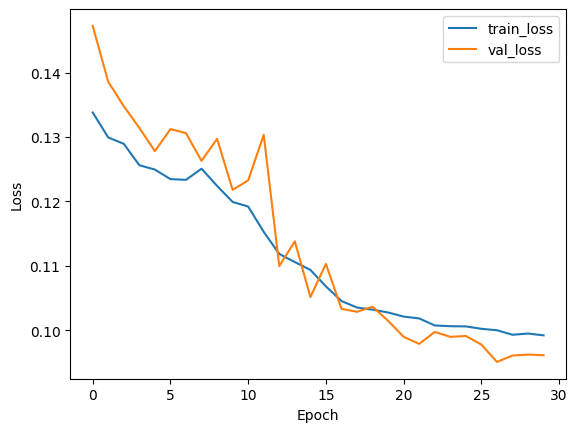

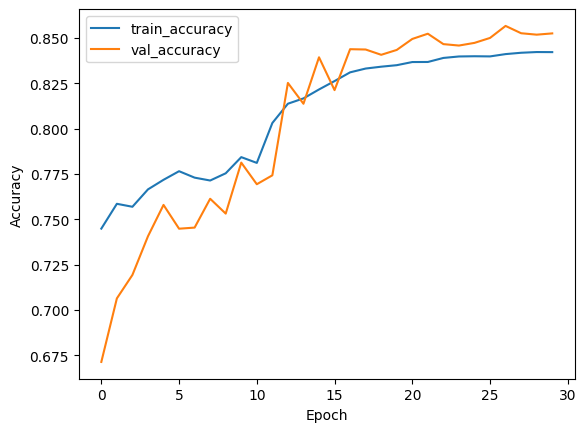

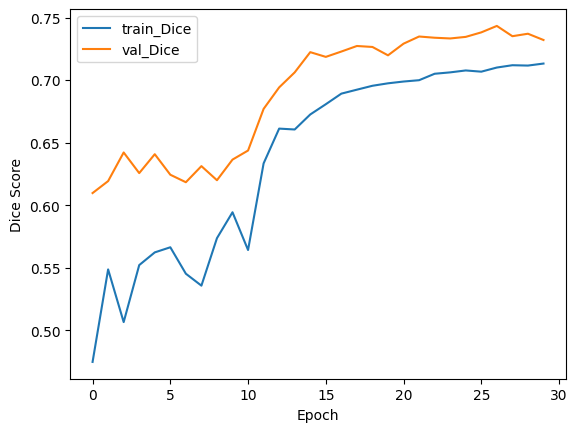

In [19]:
# 1) Loss curve
plt.figure()
plt.plot(history.history["loss"],     label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve.png", dpi=300)
plt.show()

# 2) Accuracy curve
plt.figure()
plt.plot(history.history["accuracy"],      label="train_accuracy")
plt.plot(history.history["val_accuracy"],  label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_curve.png", dpi=300)
plt.show()

# 3) Dice Score curve
plt.figure()
plt.plot(history.history["dice_coef"],     label="train_Dice")
plt.plot(history.history["val_dice_coef"], label="val_Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.savefig("dice_curve.png", dpi=300)
plt.show()


In [8]:
# If you compiled with metrics=['accuracy', dice_coef], then evaluate returns:
#    [loss, accuracy, dice_coef]
loss, accuracy, dice = model.evaluate(test_ds)

print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Dice:     {dice:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8563 - dice_coef: 0.7530 - loss: 0.0930
Test Loss:     0.0918
Test Accuracy: 0.8579
Test Dice:     0.7584


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

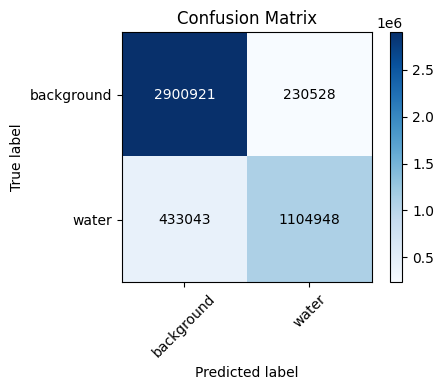

<Figure size 640x480 with 0 Axes>

In [16]:
# Build y_true, y_pred lists as before…
# (no changes here)

y_true, y_pred = [], []
for imgs, masks in test_ds:
    preds = (model.predict(imgs) > 0.5).astype(int)
    y_pred.append(preds.ravel())
    y_true.append(masks.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)


cm = confusion_matrix(y_true, y_pred)
classes = ["background", "water"]

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i,j], ha="center", va="center",
             color="white" if cm[i,j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_unet.jpg", dpi=300)


Test ROC AUC: 0.9036


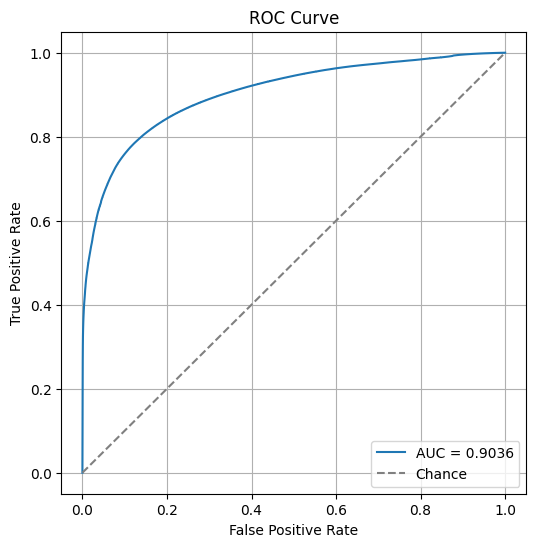

<Figure size 640x480 with 0 Axes>

In [17]:


# 1) Gather probabilities & labels
y_true, y_prob = [], []
for imgs, masks in test_ds:
    probs = model.predict(imgs, verbose=0)[...,0]  # (batch, H, W)
    y_prob.append(probs.ravel())
    y_true.append(masks.numpy().ravel())

y_prob = np.concatenate(y_prob)
y_true = np.concatenate(y_true)

# 2) Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)
print(f"Test ROC AUC: {auc:.4f}")

# 3) Plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
plt.savefig("auc_unet.jpg", dpi=300)


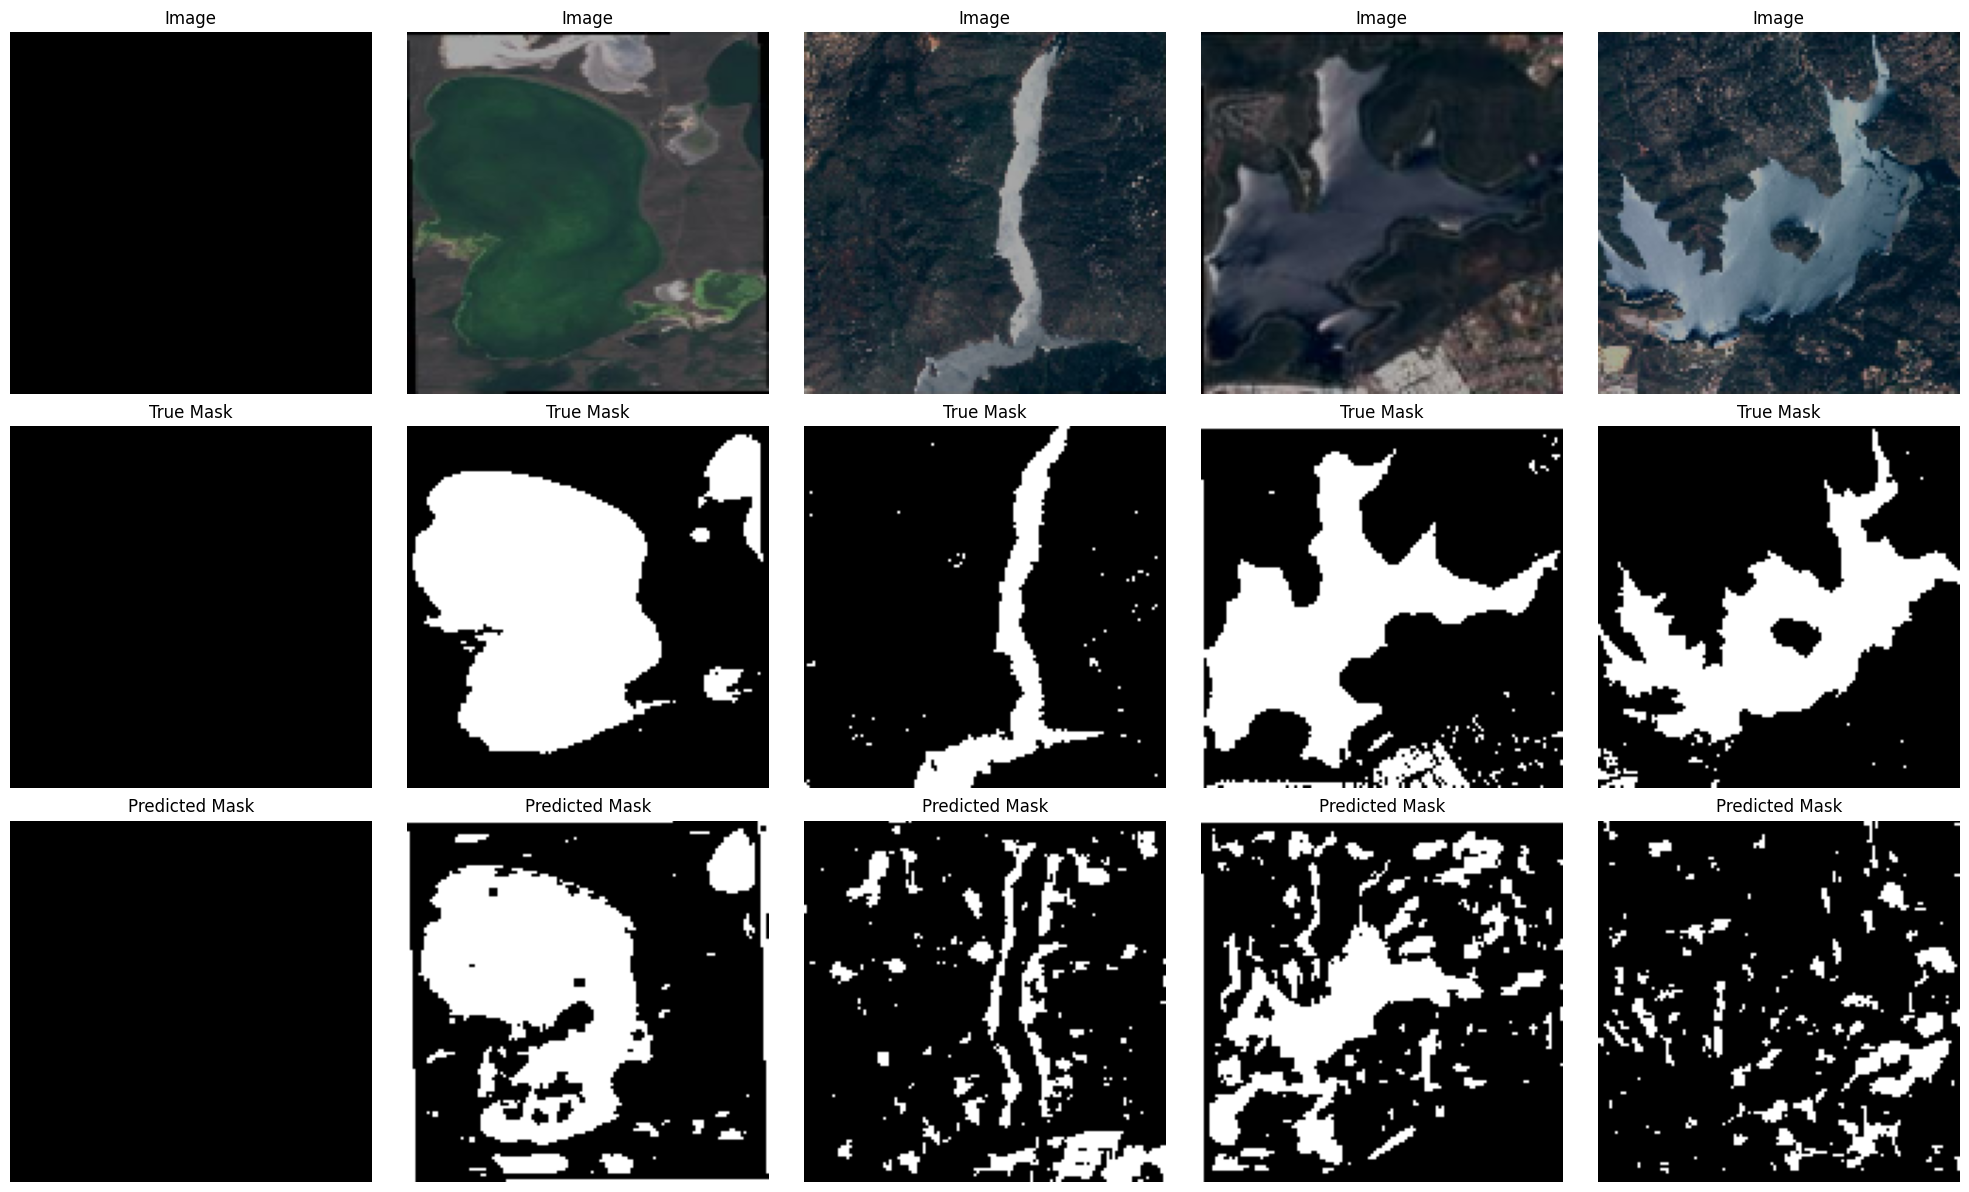

<Figure size 640x480 with 0 Axes>

In [18]:
def visualize_test_predictions(dataset, model, num_examples=5):
    """
    Displays `num_examples` samples from `dataset` with:
      - Left:  input image
      - Center: ground-truth mask
      - Right: predicted mask (thresholded 0.5)
    """
    # Unbatch so we can take individual samples
    ds = dataset.unbatch().batch(1)
    
    plt.figure(figsize=(num_examples * 4, 3 * 4))
    
    for i, (img_batch, mask_batch) in enumerate(ds.take(num_examples)):
        # img_batch: (1, H, W, 3), mask_batch: (1, H, W, 1)
        img  = img_batch[0].numpy()
        true = mask_batch[0,...,0].numpy()
        
        # Predict on this single image
        pred_prob = model.predict(img_batch, verbose=0)[0,...,0]
        pred = (pred_prob > 0.5).astype(np.uint8)
        
        # Plot input image
        ax = plt.subplot(3, num_examples, i+1)
        ax.imshow(img)
        ax.set_title("Image")
        ax.axis("off")
        
        # Plot true mask
        ax = plt.subplot(3, num_examples, num_examples + i+1)
        ax.imshow(true, cmap="gray")
        ax.set_title("True Mask")
        ax.axis("off")
        
        # Plot predicted mask
        ax = plt.subplot(3, num_examples, 2*num_examples + i+1)
        ax.imshow(pred, cmap="gray")
        ax.set_title("Predicted Mask")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
    plt.savefig("output_unet.jpg", dpi=300)

# Usage: show 5 examples from your test set
visualize_test_predictions(test_ds, model, num_examples=5)
